In [1]:
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt

from streamtomocupy import config
from streamtomocupy import streamrecon
from streamtomocupy import find_center_vo

%matplotlib inline


In [2]:
def get_data_pars(args, proj, flat, dark):
    '''Get parameters of the data'''

    args.nproj = proj.shape[0]
    args.nz = proj.shape[1]
    args.n = proj.shape[2]
    args.nflat = flat.shape[0]
    args.ndark = dark.shape[0]
    args.in_dtype = proj.dtype    
    return args        

### init parameters with default values. can be done ones and then commented

In [3]:
# config.write_args('test.conf')

## file test.conf can be edited to adjust reconstruction parameters as in tomocupy

In [4]:
# read parameters
args = config.read_args('test.conf')

## read data and set data sizes and dtype

In [5]:
with h5py.File('test_data.h5','r') as fid:
    proj = fid['exchange/data'][:]
    flat = fid['exchange/data_white'][:]
    dark = fid['exchange/data_dark'][:]
    theta = fid['exchange/theta'][:]/180*np.pi

args = get_data_pars(args,proj, flat, dark)

### find rotation axis automatically (if needed)

In [6]:
center_search_width = 100
center_search_step = 0.5
center_search_ind = proj.shape[1]//2
args.rotation_axis = find_center_vo(proj[:,center_search_ind], dark[:,center_search_ind], flat[:,center_search_ind],
                                    smin=-center_search_width, 
                                    smax=center_search_width, 
                                    step=center_search_step)
print('auto rotation axis',args.rotation_axis)


auto rotation axis 784.0


### create streaming reconstruction class, which involves allocation of pinned and gpu memory buffers, creating streams for several gpus

In [7]:
t = time.time()
cl_recstream = streamrecon.StreamRecon(args)
print('Create class, time', time.time()-t)

class created
Create class, time 2.478436231613159


## res array contains intermediate reconstruction resutls on cpu
#### res[0] - result of the first step, processing by sinogram chunks
#### res[1] - result of the sectond step, processing by projection chunks
#### res[2] - result of the third step, reconstruction by sinogram chunks

In [8]:
res = cl_recstream.get_res()

## Example 1. Full reconstruction by sinogram chunks 

In [9]:
t = time.time()
cl_recstream.rec(proj, dark, flat, theta)
print('Reconstruction by sinogram chunks, time', time.time()-t)

Reconstruction by sinogram chunks, time 0.08897519111633301


norm of the result 6.032075


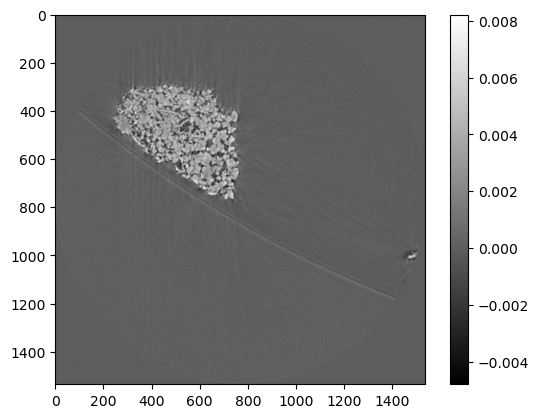

In [10]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[2][0],cmap='gray')
plt.colorbar()
plt.show()

norm of the result 6.032075


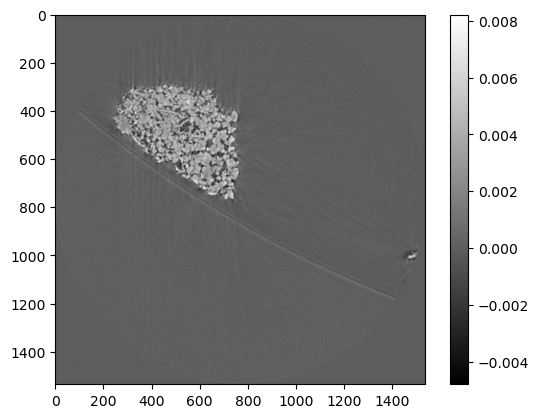

In [11]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[2][0],cmap='gray')
plt.colorbar()
plt.show()

## Example 2. Full reconstruction by sinogram and projection chunks 

In [12]:
args.retrieve_phase_method='paganin'
# processing and reconstruction
t = time.time()
cl_recstream.rec_steps(proj, dark, flat, theta)
print('Reconstruction by sinogram and projection chunks, time', time.time()-t)


Reconstruction by sinogram and projection chunks, time 0.4992103576660156


norm of the result 4.797695


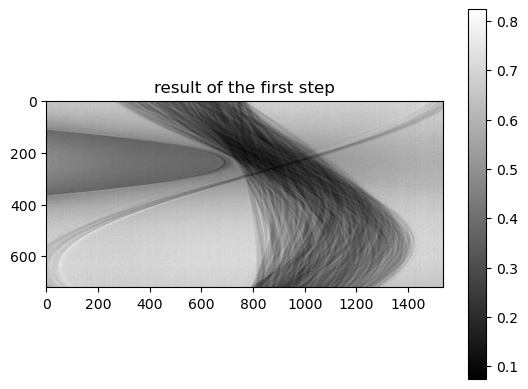

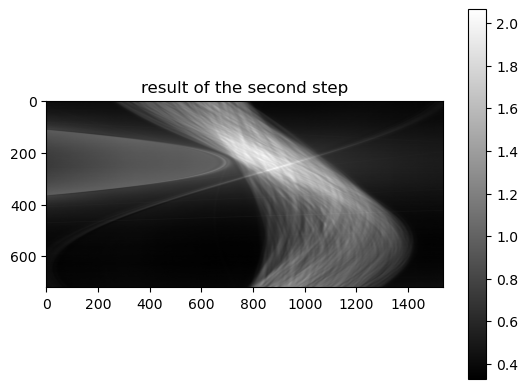

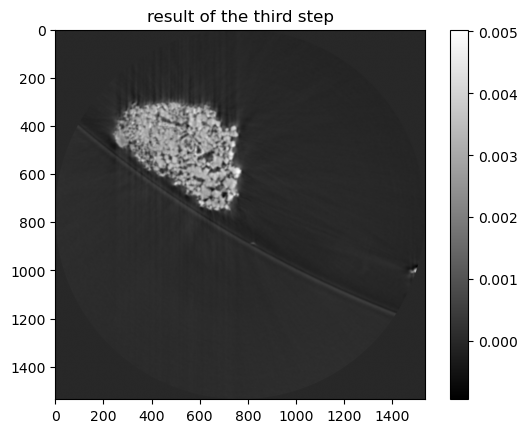

In [13]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[0][:,0],cmap='gray')
plt.title('result of the first step')
plt.colorbar()
plt.show()

plt.imshow(res[1][:,res[1].shape[1]//2],cmap='gray')
plt.title('result of the second step')
plt.colorbar()
plt.show()

plt.imshow(res[2][res[2].shape[0]//2],cmap='gray')
plt.title('result of the third step')
plt.colorbar()
plt.show()

## Example 3. Full reconstruction by sinogram and projection chunks, manual selection of slices 

Manual processing and reconstruction by sinogram and projection chunks, time 0.08770561218261719
norm of the result 3.4318511


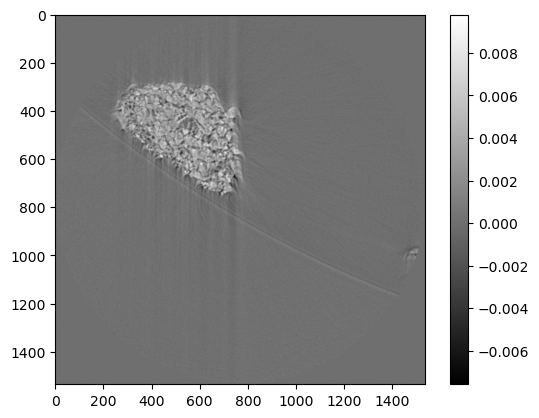

In [14]:
st = 4
end = 11
args.rotation_axis = -1
t = time.time()
args.retrieve_phase_method = 'none'
cl_recstream.proc_sino(res[0][:,st:end], proj[:,st:end], dark[:,st:end], flat[:,st:end])
cl_recstream.proc_proj(res[1][:,st:end], res[0][:,st:end])
cl_recstream.rec_sino(res[2][st:end], res[1][:,st:end], theta[:])
print('Manual processing and reconstruction by sinogram and projection chunks, time', time.time()-t)
print('norm of the result', np.linalg.norm(res[2][st:end].astype('float32')))
plt.imshow(res[2][4],cmap='gray')
plt.colorbar()
plt.show()

## Example 4. Rotation center search, after processing

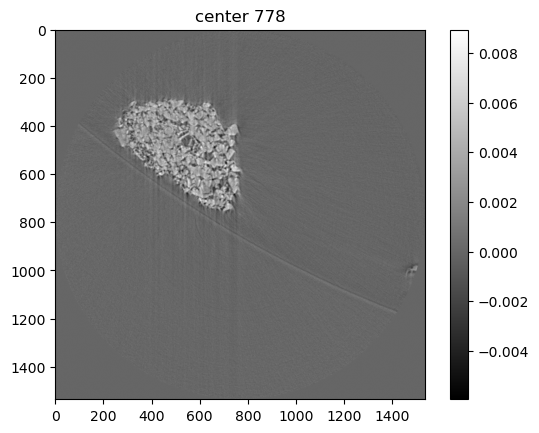

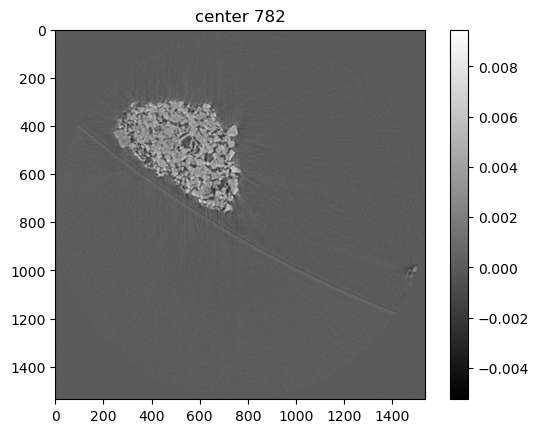

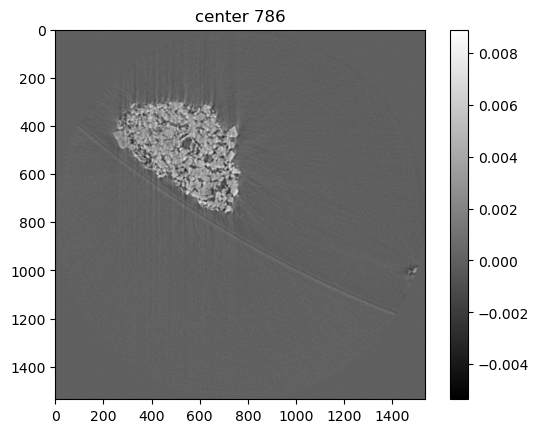

In [15]:
cl_recstream.proc_sino(res[0], proj, dark, flat)
cl_recstream.proc_proj(res[1], res[0])

st = 4
end = 5
for k in range(0,12,4):
    args.rotation_axis = 784+k-6
    cl_recstream.rec_sino(res[2][k:k+1], res[1][:,st:end], theta)

for k in range(0,12,4):
    plt.title(f'center {784+k-6}')
    plt.imshow(res[2][k],cmap='gray')
    plt.colorbar()
    plt.show()


## Example 5. Phase retrieval parameter search

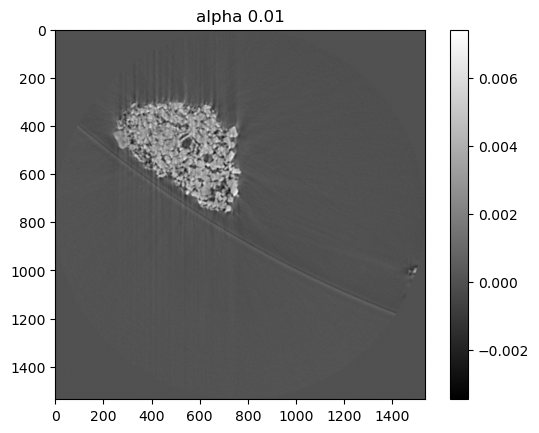

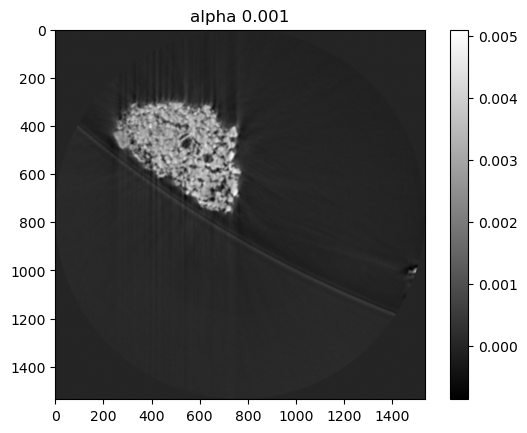

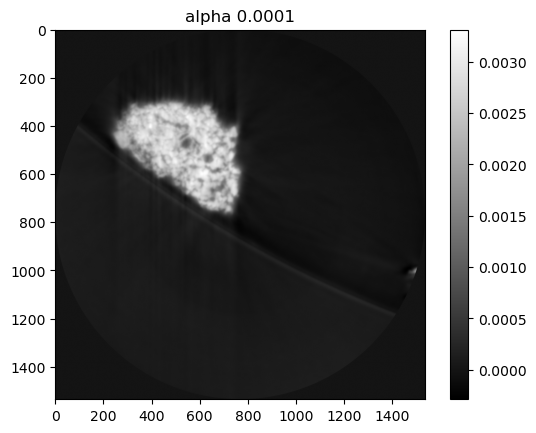

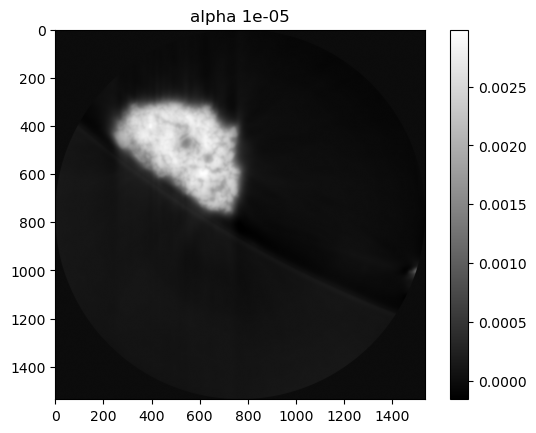

In [16]:
cl_recstream.proc_sino(res[0], proj, dark, flat)
args.retrieve_phase_method = 'paganin'
st = 5
end = 6
for k in range(4):
    args.retrieve_phase_alpha = 10**(-k-2)
    cl_recstream.proc_proj(res[1], res[0])
    cl_recstream.rec_sino(res[2][k:k+1], res[1][:,st:end], theta)

   
for k in range(4):
    plt.title(f'alpha {10**(-k-2)}')
    plt.imshow(res[2][k],cmap='gray')
    plt.colorbar()
    plt.show()


## Example 6. Full reconstruction by sinogram chunks, use subset of angles 

In [17]:
t = time.time()
cl_recstream.rec(proj[:400], dark, flat, theta[:400])
print('Reconstruction by sinogram chunks, time', time.time()-t)

Reconstruction by sinogram chunks, time 0.051049232482910156


norm of the result 8.365675


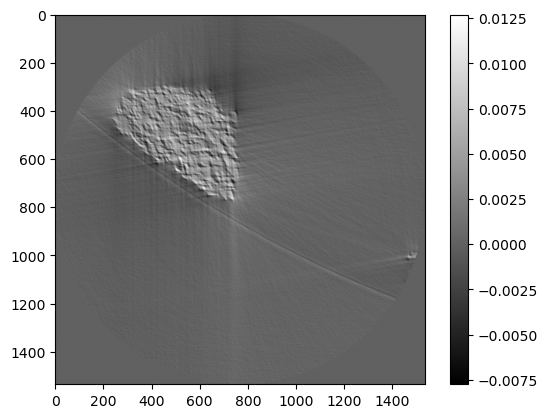

In [18]:
print('norm of the result', np.linalg.norm(res[2].astype('float32')))
plt.imshow(res[2][0],cmap='gray')
plt.colorbar()
plt.show()

## Example 7. Full reconstruction by sinogram and projection chunks, manual selection of slices, and projection angles 

Manual processing and reconstruction by sinogram and projection chunks, time 0.05877947807312012
norm of the result 4.1617613


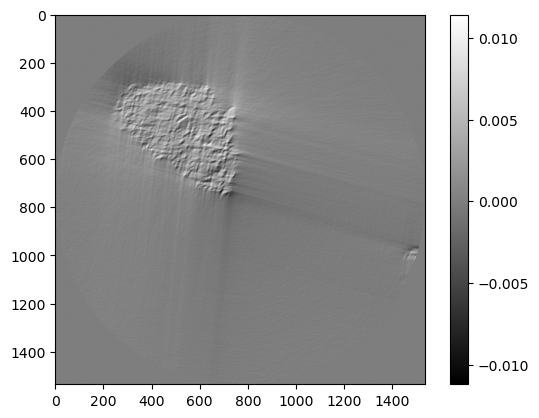

In [ ]:
st = 4
end = 11
st_proj = 300
end_proj = 700
args.rotation_axis = -1
args.retrieve_phase_method = 'none'

t = time.time()
cl_recstream.proc_sino(res[0][st_proj:end_proj,st:end], proj[st_proj:end_proj,st:end], dark[:,st:end], flat[:,st:end])
cl_recstream.proc_proj(res[1][st_proj:end_proj,st:end], res[0][st_proj:end_proj,st:end])
cl_recstream.rec_sino(res[2][st:end], res[1][st_proj:end_proj,st:end], theta[st_proj:end_proj])
print('Manual processing and reconstruction by sinogram and projection chunks, time', time.time()-t)
print('norm of the result', np.linalg.norm(res[2][st:end].astype('float32')))
plt.imshow(res[2][4],cmap='gray')
plt.colorbar()
plt.show()